In [411]:
import pickle
import typing
from copy import deepcopy
from functools import partial

import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from utils.game_utils import GymState
import Agents
from Main import MNet, game_from_name, DotDict
from Games.Game import Game
from utils.loss_utils import support_to_scalar
import MuZero
from MuZero.MuCoach import MuZeroCoach
from Coach import Coach

In [2]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

## Trained Model I/O

In [399]:
def load_run(config_file: str, game_id: str) -> typing.Tuple[DotDict, Game, MNet]:
    c = DotDict.from_json(config_file)
    g = game_from_name(game_id)
    
    net = MNet(g, c.net_args, c.architecture)
    net.load_checkpoint(c.args.load_folder_file[0], c.args.load_folder_file[1])
    
    return DotDict(file=config_file, config=c, game=g, net=net)


load_mc_run = partial(load_run, game_id='gym_MountainCar-v0')

In [620]:
my_runs = DotDict(
#     kl=load_mc_run("out/mc_out/kl/MC_Base_kl_Gym_gym_MountainCar-v0_20201130-111910.json"),
    l4=load_mc_run("out/mc_out/latent_4/MC_Base_Gym_gym_MountainCar-v0_20201129-132609.json"),
#     l8=load_mc_run("out/mc_out/latent_8/MC_Base_Gym_gym_MountainCar-v0_20201130-111621.json")
)


# my_runs.kl.experiment = 'out/mc_out/kl/MC_BlindfoldMuZero_kl_20201201-101835.out'
my_runs.l4.experiment = 'out/mc_out/latent_4/MC_BlindfoldMuZero_l4_20201201-150406.out'
# my_runs.l8.experiment = 'out/mc_out/latent_8/MC_BlindfoldMuZero_20201201-103309.out'

## State Space Enumeration and Embedding

In [652]:
def create_grid(v_mins: typing.List, v_maxs: typing.List, resolution: int) -> np.ndarray:
    data = list(map(lambda r: np.linspace(*r, resolution), zip(v_mins, v_maxs)))
    grid = np.asarray(np.meshgrid(*data)).T.reshape(-1, len(v_mins))
    return grid


def get_state_space(g: Game, resolution: int = 25) -> np.ndarray:
    obs_space = g.getInitialState().env.observation_space
    state_space = create_grid(obs_space.low, obs_space.high, resolution)
    return state_space


def embedding_manifold(state_space: np.ndarray, net: MNet, return_pis: bool = False) -> typing.Tuple:
    if len(state_space.shape) != 4:
        state_space = state_space[:, np.newaxis, np.newaxis, :]
        
    s, pis, vs = net.neural_net.forward.predict(state_space, batch_size=512)
   
    v_reals = support_to_scalar(vs, (vs.shape[-1] - 1) / 2)
    s = s.reshape(len(state_space), -1)

    if return_pis:
        return s, v_reals, pis
    
    return s, v_reals


In [613]:
delta = 50
state_space = get_state_space(my_runs.l4.game, delta)

s, vs, *pis = embedding_manifold(state_space, my_runs.l4.net)

print(state_space.shape, s.shape)

(2500, 2) (2500, 4)


In [662]:
np.save('state_space.np', state_space)

## PCA 

In [614]:
def embedding_PCA(latent_states: np.ndarray, standardize: bool = False):   
    x = latent_states
    if standardize:
        x = (x - x.mean(axis=0)) / x.std(axis=0)
    
    # Perform PCA on latent dimensions
    pca = PCA(n_components=x.shape[-1])
    pca.fit(x)
    spca = pca.fit_transform(x)
    
    # Create barchart
    ns = list(range(x.shape[-1]))
    var = pca.explained_variance_ratio_
    
    bar = plt.bar(ns, var)
    
    plt.title(f"PCA on latent-states (standardize={standardize})")
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel("Principal Component")
    
    
    for i in range(len(var)):
        plt.annotate(f'{var[i]:.3f}', xy=(ns[i],var[i]), ha='center', va='bottom')

    plt.show()
    
    return pca

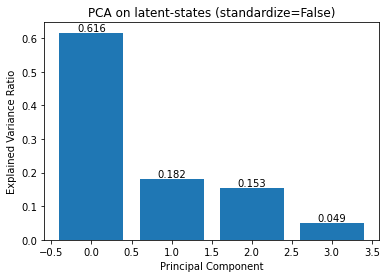

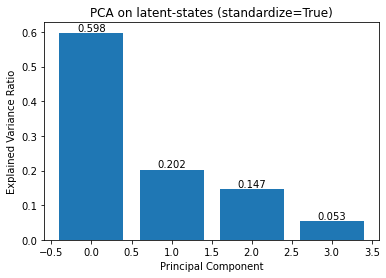

In [616]:
pca = embedding_PCA(s, False)
pca_norm = embedding_PCA(s, True)

pcs = pca_norm.transform(s)

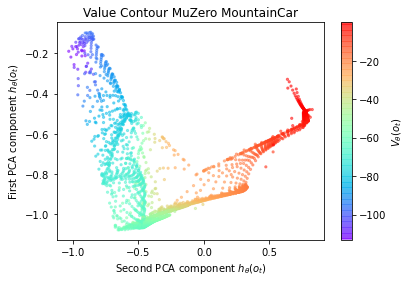

In [617]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=vs, alpha=0.5, s=5, cmap='rainbow')

cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"First PCA component $h_\theta(o_t)$")
plt.xlabel(r"Second PCA component $h_\theta(o_t)$")

plt.show()

## Plot Helpers

In [618]:
def to_grid(x: np.ndarray, delta: int) -> np.ndarray:
    return x.reshape(delta, delta)


def simple_MC_value_contour(x: np.ndarray, y: np.ndarray, z: np.ndarray) -> None:
    # Simple Example Figure for a 2-d env
    plt.title("Value Contour MuZero MountainCar")
    plt.ylabel("Velocity")
    plt.xlabel("Position")

    plt.contourf(x, y, z, levels=100, cmap='rainbow')

    cbar = plt.colorbar()
    cbar.set_label(r'$V_\theta(o_t)$')

    plt.show()
    

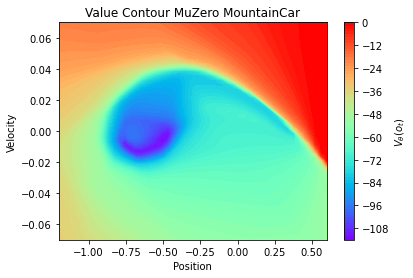

In [619]:
simple_MC_value_contour(to_grid(state_space[:,0], delta), to_grid(state_space[:,1], delta), to_grid(vs, delta))

## Trajectory Generation with MDP Observation Sparsity

In [561]:
def load_experiment(experiment_out_file: str, net: MNet) -> DotDict:
    with open(experiment_out_file, 'rb') as f:
        history = pickle.load(f)
    
    data = DotDict()
    for run in history:
        k, *_= run.keys()
        v = run.values()
        
        observations = list()
        actions = list()
        embeddings = list()
        
        for trajectory in list(*v):
            if len(trajectory) > 0:
                obs = np.asarray(trajectory.observations)
                acts = np.asarray(trajectory.actions)
                
                observations.append(obs)
                actions.append(acts)
                
                # Projected trajectories -- h(o_t). Not equal to latent trajectories!
                embeddings.append(net.neural_net.encoder.predict(obs, batch_size=512))
        
        data[k] = DotDict(observations=observations, actions=actions, embeddings=embeddings)
        
    return data


def get_latent_trajectory(embeddings: np.ndarray, actions: np.ndarray, g: Game, net: MNet, refresh_freq: int) -> np.ndarray:
    memory = embeddings[0][np.newaxis,...]
    
    latent_states = list()
    for i in range(len(embeddings)):
        if i % refresh_freq == 0:
            s = embeddings[i][np.newaxis, ...]
        else:
            # One hot encoding
            a = np.zeros((1, g.getActionSize()))
            a[:, actions[i]] = 1
            
            r, s = net.neural_net.dynamics.predict([memory, a])
        
        memory = s
        latent_states.append(s)
        
    stacked = np.concatenate(latent_states)
    return stacked

In [626]:
trajectories = load_experiment(my_runs.l4.experiment, my_runs.l4.net)

In [629]:
sample = trajectories.r0c3_BlindMuZeroPlayer_MC_Base
sample_trajectory = get_latent_trajectory(sample.embeddings[0], sample.actions[0], my_runs.l4.game, my_runs.l4.net, 200)

# Project to PC-space
pc_embedding_trajectory = pca_norm.transform(sample.embeddings[0].reshape(len(sample.embeddings[0]), -1))
pc_dynamics_trajectory = pca_norm.transform(sample_trajectory.reshape(len(sample_trajectory), -1))

## Trajectory and Abstract MDP Visualization in Plotly

In [647]:
def generate_3d_surface(x: np.ndarray, y: np.ndarray, z: np.ndarray, colors: np.ndarray):
    return go.Surface(
        x=x, y=y, z=z,
        opacity=0.9, 
        surfacecolor=colors,
        cmin=colors.min(),
        cmax=colors.max(),
        colorbar=dict(title=dict(text='V',side='top'), thickness=50,tickmode='array')
    )

def generate_3d_trajectory(x: np.ndarray, y: np.ndarray, z: np.ndarray, color: str):
    return go.Scatter3d(
        x=x + np.random.rand()*0.01,
        y=y + np.random.rand()*0.01,
        z=z + np.random.rand()*0.01,
        mode='lines+markers',
        marker=dict(
            size=3,
            symbol='x',
            color=color,
            opacity=1
        ),
        line=dict(
            color=color,
            width=10
        )
    )

In [608]:
embedding_trajectory =  generate_3d_trajectory(
    pc_embedding_trajectory[:, 0],
    pc_embedding_trajectory[:, 1], 
    pc_embedding_trajectory[:, 2], 'grey')

dynamics_trajectory = generate_3d_trajectory(
    pc_dynamics_trajectory[:, 0], 
    pc_dynamics_trajectory[:, 1], 
    pc_dynamics_trajectory[:, 2], 'black')

surface = generate_3d_surface(to_grid(pcs[:,0], delta), to_grid(pcs[:,1], delta), 
                              to_grid(pcs[:,2], delta), to_grid(vs, delta))


cube = go.Scatter3d(
    x=latent_grid[:,0],
    y=latent_grid[:,1],
    z=latent_grid[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=latent_grid[:,2],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.08
    )
)

fig = go.Figure(data=[embedding_trajectory, dynamics_trajectory, surface])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis=dict(range=[-1,3/2]))
fig.show()


In [648]:
embedding_trajectory =  generate_3d_trajectory(
    pc_embedding_trajectory[:, 0],
    pc_embedding_trajectory[:, 1], 
    pc_embedding_trajectory[:, 2], 'grey')

dynamics_trajectory = generate_3d_trajectory(
    pc_dynamics_trajectory[:, 0], 
    pc_dynamics_trajectory[:, 1], 
    pc_dynamics_trajectory[:, 2], 'black')

surface = generate_3d_surface(to_grid(pcs[:,0], delta), to_grid(pcs[:,1], delta), 
                              to_grid(pcs[:,2], delta), to_grid(pcs[:,3], delta))


cube = go.Scatter3d(
    x=latent_grid[:,0],
    y=latent_grid[:,1],
    z=latent_grid[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=latent_grid[:,2],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.08
    )
)

fig = go.Figure(data=[embedding_trajectory, dynamics_trajectory, surface])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis=dict(range=[-1,3/2]))
fig.show()


In [166]:


cmap = plt.get_cmap("rainbow")
colorscale = [[0, 'rgb' + str(cmap(1)[0:3])], 
              [1, 'rgb' + str(cmap(2)[0:3])]]

marker_data = go.Surface(
    x=pcs[:,0].reshape(delta,delta), 
    y=pcs[:,1].reshape(delta,delta), 
    z=sppcsca[:,2].reshape(delta,delta), 
#     marker=go.scatter3d.Marker(size=5), 
    opacity=0.8, 
    surfacecolor=v_reals.reshape(delta, delta),
    cmin=v_reals.min(),
    cmax=v_reals.max(),
    colorbar=dict(title=dict(text='V',side='top'),
                  thickness=50,tickmode='array',),
#     mode='markers'
)

trajectory = go.Scatter3d(
    x=tsf_p[:,0]+np.random.rand()*0.01,
    y=tsf_p[:,1]+np.random.rand()*0.01,
    z=tsf_p[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='black',
        width=20
    )
)

trajectory_blind = go.Scatter3d(
    x=tsf_b[:,0]+np.random.rand()*0.01,
    y=tsf_b[:,1]+np.random.rand()*0.01,
    z=tsf_b[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='grey',
        width=20
    )
)

layout = go.Layout(scene = dict(
    xaxis = dict(title='PC 1'), yaxis = dict(title='PC 2'), zaxis = dict(title='PC 3')), 
                   title='Embedding Manifold in 3-Principal Component space', autosize=False,
                   width=800, height=800,
                   margin=dict(l=65, r=50, b=65, t=90)
                  )

fig=go.Figure(data=[marker_data, trajectory, trajectory_blind], layout=layout)


fig.show()

In [226]:


cmap = plt.get_cmap("rainbow")
colorscale = [[0, 'rgb' + str(cmap(1)[0:3])], 
              [1, 'rgb' + str(cmap(2)[0:3])]]

marker_data = go.Surface(
    x=spca[:,0].reshape(delta,delta), 
    y=spca[:,1].reshape(delta,delta), 
    z=spca[:,2].reshape(delta,delta), 
#     marker=go.scatter3d.Marker(size=5), 
    opacity=0.8, 
    surfacecolor=v_reals.reshape(delta, delta),
    cmin=v_reals.min(),
    cmax=v_reals.max(),
    colorbar=dict(title=dict(text='V',side='top'),
                  thickness=50,tickmode='array',),
#     mode='markers'
)

trajectory = go.Scatter3d(
    x=tsf_p[:,0]+np.random.rand()*0.01,
    y=tsf_p[:,1]+np.random.rand()*0.01,
    z=tsf_p[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='black',
        width=20
    )
)

trajectory_blind = go.Scatter3d(
    x=tsf_b[:,0]+np.random.rand()*0.01,
    y=tsf_b[:,1]+np.random.rand()*0.01,
    z=tsf_b[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='grey',
        width=20
    )
)

trajectory_fail = go.Scatter3d(
    x=tsf_f[:,0]+np.random.rand()*0.01,
    y=tsf_f[:,1]+np.random.rand()*0.01,
    z=tsf_f[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='red',
        width=20
    )
)

layout = go.Layout(scene = dict(
    xaxis = dict(title='PC 1'), yaxis = dict(title='PC 2'), zaxis = dict(title='PC 3')), 
                   title='Embedding Manifold in 3-Principal Component space', autosize=False,
                   width=800, height=800,
                   margin=dict(l=65, r=50, b=65, t=90)
                  )

fig=go.Figure(data=[marker_data, trajectory,trajectory_fail, trajectory_blind], layout=layout)


fig.show()

In [223]:
len(latent_out[-1][-1])

50

In [225]:
ts_blind_fail = latent_out[-1][-1][0]
tsf_f = pca.transform(ts_blind_fail)

In [201]:
tsf_p = pca.transform(ts_full)
tsf_b = pca.transform(ts_blind)

In [200]:
ts_full = latent_out[0][-1][0]
ts_blind = latent_out[-1][-1][0]

In [195]:
trajectory = go.Scatter3d(
    x=ts_full[:,3]+np.random.rand()*0.01,
    y=ts_full[:,1]+np.random.rand()*0.01,
    z=ts_full[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='black',
        width=20
    )
)

trajectory_blind = go.Scatter3d(
    x=ts_blind[:,3]+np.random.rand()*0.01,
    y=ts_blind[:,1]+np.random.rand()*0.01,
    z=ts_blind[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='grey',
        width=20
    )
)

cube = go.Scatter3d(
    x=latent_grid[:,0],
    y=latent_grid[:,1],
    z=latent_grid[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=latent_grid[:,2],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.08
    )
)

fig = go.Figure(data=[trajectory, trajectory_blind, surface])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis=dict(range=[-1,3/2]))
fig.show()

In [167]:
trajectory = go.Scatter3d(
    x=ts_full[:,3]+np.random.rand()*0.01,
    y=ts_full[:,1]+np.random.rand()*0.01,
    z=ts_full[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='black',
        width=20
    )
)

trajectory_blind = go.Scatter3d(
    x=ts_blind[:,3]+np.random.rand()*0.01,
    y=ts_blind[:,1]+np.random.rand()*0.01,
    z=ts_blind[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='grey',
        width=20
    )
)

cube = go.Scatter3d(
    x=latent_grid[:,0],
    y=latent_grid[:,1],
    z=latent_grid[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=latent_grid[:,2],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.08
    )
)

fig = go.Figure(data=[trajectory, trajectory_blind, surface])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis=dict(range=[-1,3/2]))
fig.show()

In [55]:
trajectory = go.Scatter3d(
    x=ts[:,0]+np.random.rand()*0.01,
    y=ts[:,1]+np.random.rand()*0.01,
    z=ts[:,2]+np.random.rand()*0.01,
    mode='lines',
    marker=dict(
        size=0,
        color='black',               # set color to an array/list of desired values
        opacity=0.0
    ),
    line=dict(
        color='black',
        width=20
    )
)

cube = go.Scatter3d(
    x=latent_grid[:,0],
    y=latent_grid[:,1],
    z=latent_grid[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=latent_grid[:,2],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.08
    )
)

fig = go.Figure(data=[cube, trajectory, surface])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis=dict(range=[-1,3/2]))
fig.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=1, init='pca')
s_tsne = tsne.fit_transform(s)

In [ ]:
idx = np.asarray([np.sum((p.ravel() - s) ** 2, axis=-1).argmin() for p in ts])
ts_tsne = s_tsne[idx,:]
ts_tsne.shape

In [ ]:
plt.figure(figsize=(8, 7))
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"TSNE dim 1 $h_\theta(o_t)$")
plt.xlabel(r"TSNE dim 2 $h_\theta(o_t)$")

plt.scatter(s_tsne[:, 0][terminals], s_tsne[:, 1][terminals], c='black', s=10, alpha=0.3)
plt.scatter(s_tsne[:, 0][~terminals], s_tsne[:, 1][~terminals], c=v_reals[~terminals], s=10, alpha=0.8, cmap='rainbow')
plt.plot(ts_tsne[:, 0], ts_tsne[:, 1], c='black', linestyle='--')


cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"TSNE dim 1 $h_\theta(o_t)$")
plt.xlabel(r"TSNE dim 2 $h_\theta(o_t)$")

plt.scatter(s_tsne[:, 0][terminals], s_tsne[:, 1][terminals], c='black', s=10, cmap='rainbow')
plt.scatter(s_tsne[:, 0][~terminals], s_tsne[:, 1][~terminals], c=v_reals[~terminals], s=10, cmap='rainbow')

cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [ ]:
plt.boxplot(s)
plt.show()

In [ ]:
X, V = np.meshgrid(x, v)
d = (X - X.mean()) / X.std() + (V - V.mean()) / V.std()

plt.title("Value Contour MuZero MountainCar")
plt.ylabel("Velocity")
plt.xlabel("Position")

plt.contourf(X, V, d, levels=100, cmap='rainbow')

cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"TSNE dim 1 $h_\theta(o_t)$")
plt.xlabel(r"TSNE dim 2 $h_\theta(o_t)$")

plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c=d.ravel(), s=10, cmap='rainbow')

cbar = plt.colorbar()
cbar.set_label(r'')

plt.show()

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"First PCA component $h_\theta(o_t)$")
plt.xlabel(r"Second PCA component $h_\theta(o_t)$")

plt.scatter(spca[:, 0], spca[:, 1], c=d.ravel(), s=10, cmap='rainbow')


cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [181]:
with open('out/mc_out/latent_8/MC_BlindfoldMuZero_20201201-103309.out', 'rb') as f:
    history = pickle.load(f)

In [231]:
latents = list()
for a in act_out[-1][-1][0]:
    

5

In [228]:
out = list()
latent_out = list()
act_out = list()
for trial in history:
    values = list(*trial.values())[1:]
    trajectories = [np.asarray(x.observations).reshape(len(x), 2) for x in values if len(x) < 195]
    act_t = [x.actions for x in values if len(x) < 195]
    latent_trajectories = [net.neural_net.encoder.predict(x[:, np.newaxis, np.newaxis, :])[..., 0] for x in trajectories]
    
    act_out.append((*trial.keys(), act_t))
    latent_out.append((*trial.keys(), latent_trajectories))
    out.append((*trial.keys(), trajectories))

[50, 50, 50, 50, 31]


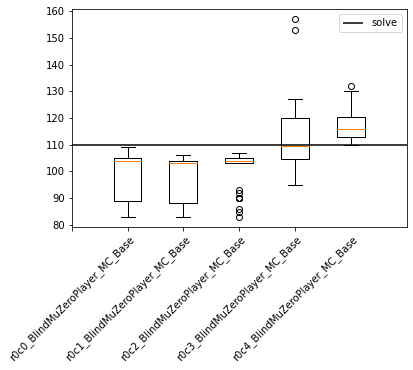

In [183]:
results = ([(t[0], list(map(len, t[1]))) for t in out])
print([len(x[1]) for x in latent_out])
plt.boxplot([x[1] for x in results])
plt.xticks(range(len(results)), [x[0] for x in results], rotation=45)
plt.hlines(110, -1, 6, color='black', label='solve')

plt.legend()
plt.xlim(0, 6)
plt.show()

In [219]:
with open('out/mc_out/kl/MC_BlindfoldMuZero_kl_20201201-101835.out', 'rb') as f:
    history = pickle.load(f)

In [222]:
out = list()
latent_out = list()
for trial in history:
    values = list(*trial.values())[1:]
    trajectories = [np.asarray(x.observations).reshape(len(x), 2) for x in values]
    latent_trajectories = [net.neural_net.encoder.predict(x[:, np.newaxis, np.newaxis, :])[..., 0] for x in trajectories]
    
    latent_out.append((*trial.keys(), latent_trajectories))
    out.append((*trial.keys(), trajectories))

In [221]:
[len(x[1]) for x in latent_out]

[50, 50, 50, 36, 5]

[50, 50, 50, 36, 5]


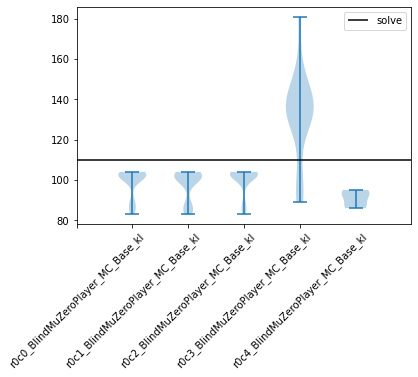

In [368]:
results = ([(t[0], list(map(len, t[1]))) for t in out])
print([len(x[1]) for x in latent_out])
plt.violinplot([x[1] for x in results])
plt.xticks(range(len(results)), [x[0] for x in results], rotation=45)
plt.hlines(110, -1, 6, color='black', label='solve')

plt.legend()
plt.xlim(0, 6)
plt.show()

In [33]:
print(*map(len, trajectories))

194 149 183 111 172 92 178 110 155 186 164 118 151 112 154 150 167 118 119


C:\Users\joery\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



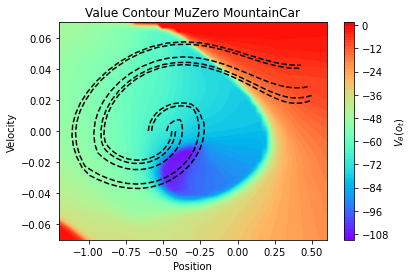

In [97]:
X, V = np.meshgrid(x, v)
Z = v_reals.reshape(delta, delta)

plt.title("Value Contour MuZero MountainCar")
plt.ylabel("Velocity")
plt.xlabel("Position")

plt.contourf(X, V, Z, levels=100, cmap='rainbow')

for t in np.random.choice(trajectories, 5):
    plt.plot(t[::2, 0], t[::2, 1], c = 'black', linestyle='--')

cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [99]:
ts, tvs, tpis = net.neural_net.forward.predict(trajectories[0][:, np.newaxis, np.newaxis, :], batch_size=256)

In [102]:
ts.shape

(104, 8)

In [101]:
ts = ts.reshape(len(trajectories[0]), -1)

In [ ]:
pca_trajectory = pca.transform(ts)

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"First PCA component $h_\theta(o_t)$")
plt.xlabel(r"Second PCA component $h_\theta(o_t)$")

plt.scatter(spca[:, 0], spca[:, 1], c=Z, s=10, cmap='rainbow')
plt.plot(pca_trajectory[:, 0], pca_trajectory[:, 1], c='black', linestyle='--')

cbar = plt.colorbar()
cbar.set_label(r'$V_\theta(o_t)$')

plt.show()

In [ ]:
idx = np.asarray([np.sum((p - s) ** 2, axis=-1).argmin() for p in ts])
ts_tsne = s_tsne[idx,:]
ts_tsne.shape

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"TSNE dim 1 $h_\theta(o_t)$")
plt.xlabel(r"TSNE dim 2 $h_\theta(o_t)$")

plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c=Z, s=10, cmap='rainbow')
plt.plot(ts_tsne[:, 0], ts_tsne[:, 1], c='black', linestyle='--')

ts_tsne

cbar = plt.colorbar()
cbar.set_label(r'')

plt.show()

In [ ]:
s.shape

In [ ]:
embedding = MDS(max_iter=100, n_init=1, verbose=100)
# embedding = LocallyLinearEmbedding(n_neighbors = 100, n_components=2)
s_mds = embedding.fit_transform(s)

In [ ]:
idx = np.asarray([np.sum((p - s[:,0]) ** 2, axis=-1).argmin() for p in ts])
ts_mds = s_mds[idx,:]
ts_mds.shape

In [ ]:
plt.title("Value Contour MuZero MountainCar")
plt.ylabel(r"TSNE dim 1 $h_\theta(o_t)$")
plt.xlabel(r"TSNE dim 2 $h_\theta(o_t)$")

plt.scatter(s_mds[:, 0], s_mds[:, 1], c=Z, s=5, cmap='rainbow', alpha=0.2)
plt.plot(ts_mds[:, 0], ts_mds[:, 1], c='black', linestyle='--')

cbar = plt.colorbar()
cbar.set_label(r'')

plt.show()

In [ ]:
X.shape, V.shape, Z.shape

In [ ]:
s_mds[:,0].reshape(delta, delta)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(s_mds[:,0].reshape(delta, delta), 
                       s_mds[:,1].reshape(delta, delta), 
                       s_mds[:,2].reshape(delta, delta), cmap='rainbow', rcount=1000, ccount=1000, linewidth=0, antialiased=False)

